* 18.05: Updated competition metric

## Imports

In [1]:
import sys
sys.path.append('../input/iterativestratification')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew, kurtosis
import warnings

from sklearn.preprocessing import LabelEncoder
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from tqdm.auto import tqdm
import catboost as cb


from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
cust_color = [
    '#EDC7B7',
    '#EEE2DC',
    '#BAB2B5',
    '#123C69',
    '#AC3B61'
]
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['figure.dpi'] = 300
plt.rcParams["axes.grid"] = False
plt.rcParams["grid.color"] = cust_color[3]
plt.rcParams["grid.alpha"] = 0.5
plt.rcParams["grid.linestyle"] = '--'
plt.rcParams["font.family"] = "monospace"

plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['figure.frameon'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.linewidth'] = 0.5

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Loading

In [2]:
train = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
greeks = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')
test = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')

train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()

In [3]:
num_cols = train.columns.tolist()[1:-1]
cat_cols = 'EJ'
num_cols.remove(cat_cols)

# Features of Interest

In [4]:
features_std = train.loc[:,num_cols].apply(lambda x: np.std(x)).sort_values(
    ascending=False)
f_std = train[features_std.iloc[:20].index.tolist()]

with pd.option_context('mode.use_inf_as_na', True):
    features_skew = np.abs(train.loc[:,num_cols].apply(lambda x: np.abs(skew(x))).sort_values(
        ascending=False)).dropna()
skewed = train[features_skew.iloc[:20].index.tolist()]

with pd.option_context('mode.use_inf_as_na', True):
    features_kurt = np.abs(train.loc[:,num_cols].apply(lambda x: np.abs(kurtosis(x))).sort_values(
        ascending=False)).dropna()
kurt_f = train[features_kurt.iloc[:20].index.tolist()]

In [5]:
def feat_dist(df, cols, rows=3, columns=3, title=None, figsize=(30, 25)):
    
    fig, axes = plt.subplots(rows, columns, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()

    for i, j in zip(cols, axes):
        sns.kdeplot(df, x=i, ax=j, hue='Class', linewidth=1.5, linestyle='--')
        
        (mu, sigma) = norm.fit(df[i])
        
        xmin, xmax = j.get_xlim()[0], j.get_xlim()[1]
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, sigma)
        j.plot(x, p, 'k', linewidth=2)
        
        j.set_title('Dist of {0} Norm Fit: $\mu=${1:.2g}, $\sigma=${2:.2f}'.format(i, mu, sigma), weight='bold')
        j.legend(labels=[f'Class0_{i}', f'Class1_{i}', 'Normal Dist'])
        fig.suptitle(f'{title}', fontsize=24, weight='bold')

### Instead of creating a big blob with every feature I select some features with odd statistics

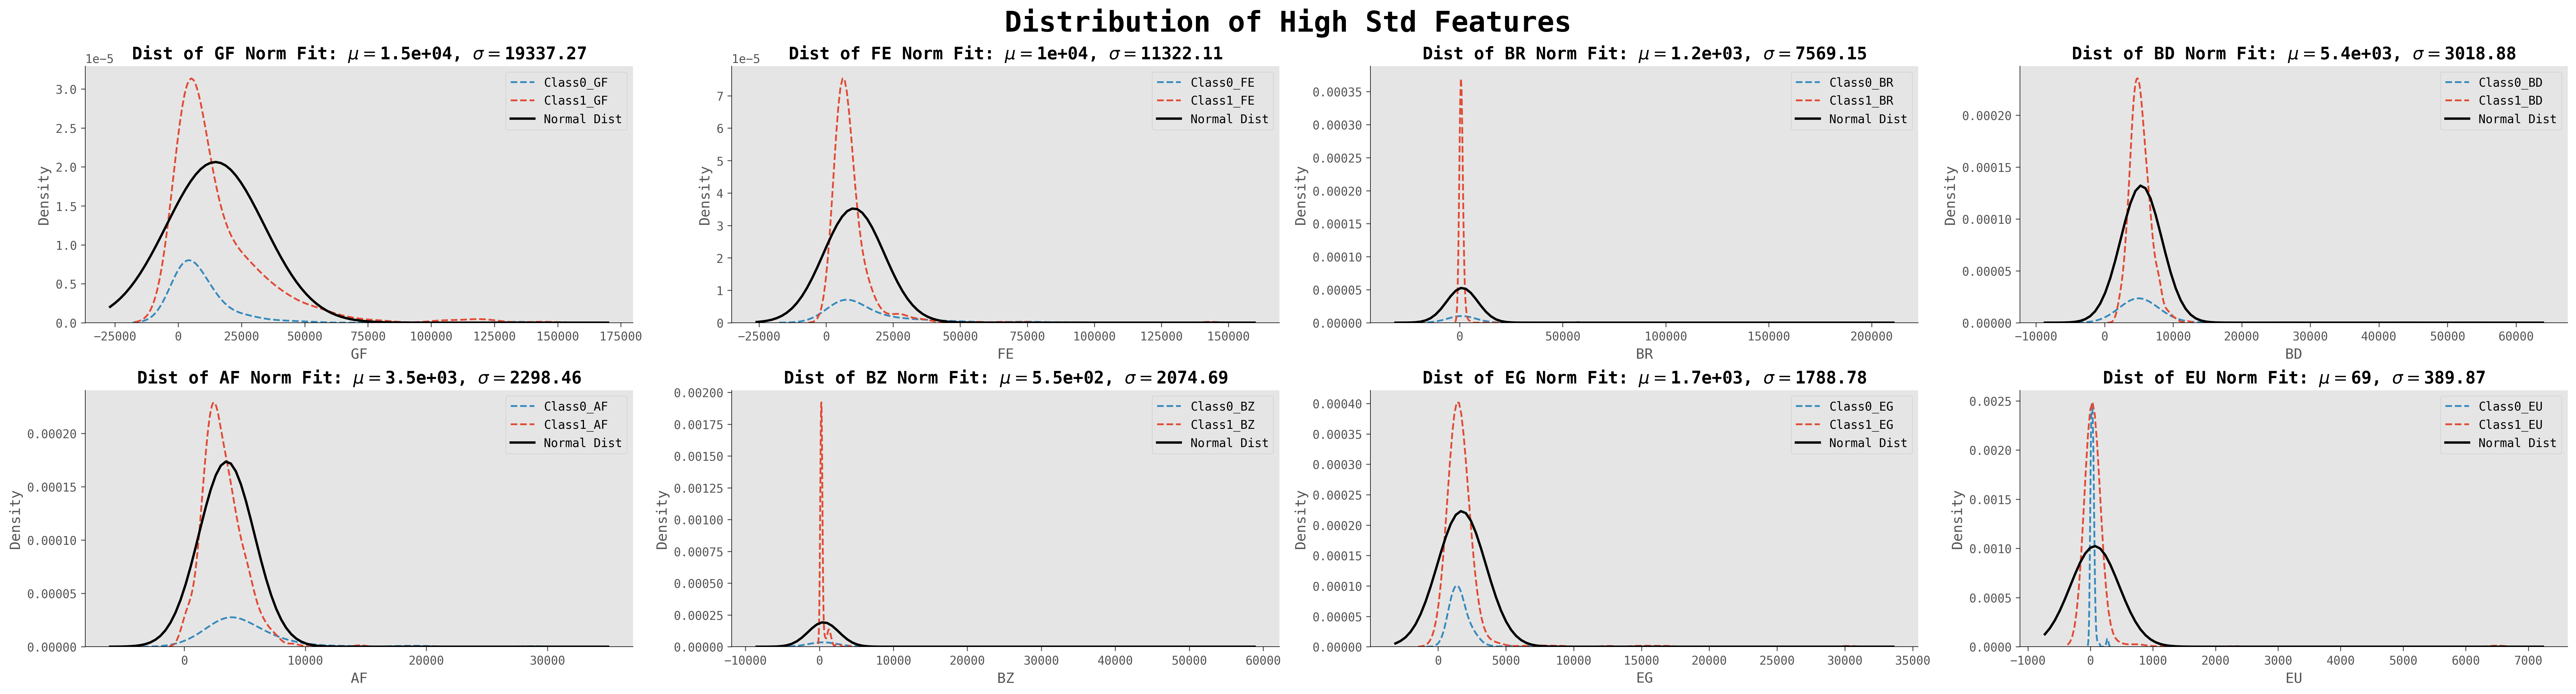

In [6]:
feat_dist(train, f_std.columns.tolist(), rows=2, columns=4, title='Distribution of High Std Features', figsize=(30, 8))

### You can notice pretty big difference between class 0 and class 1 distributions in odd features...

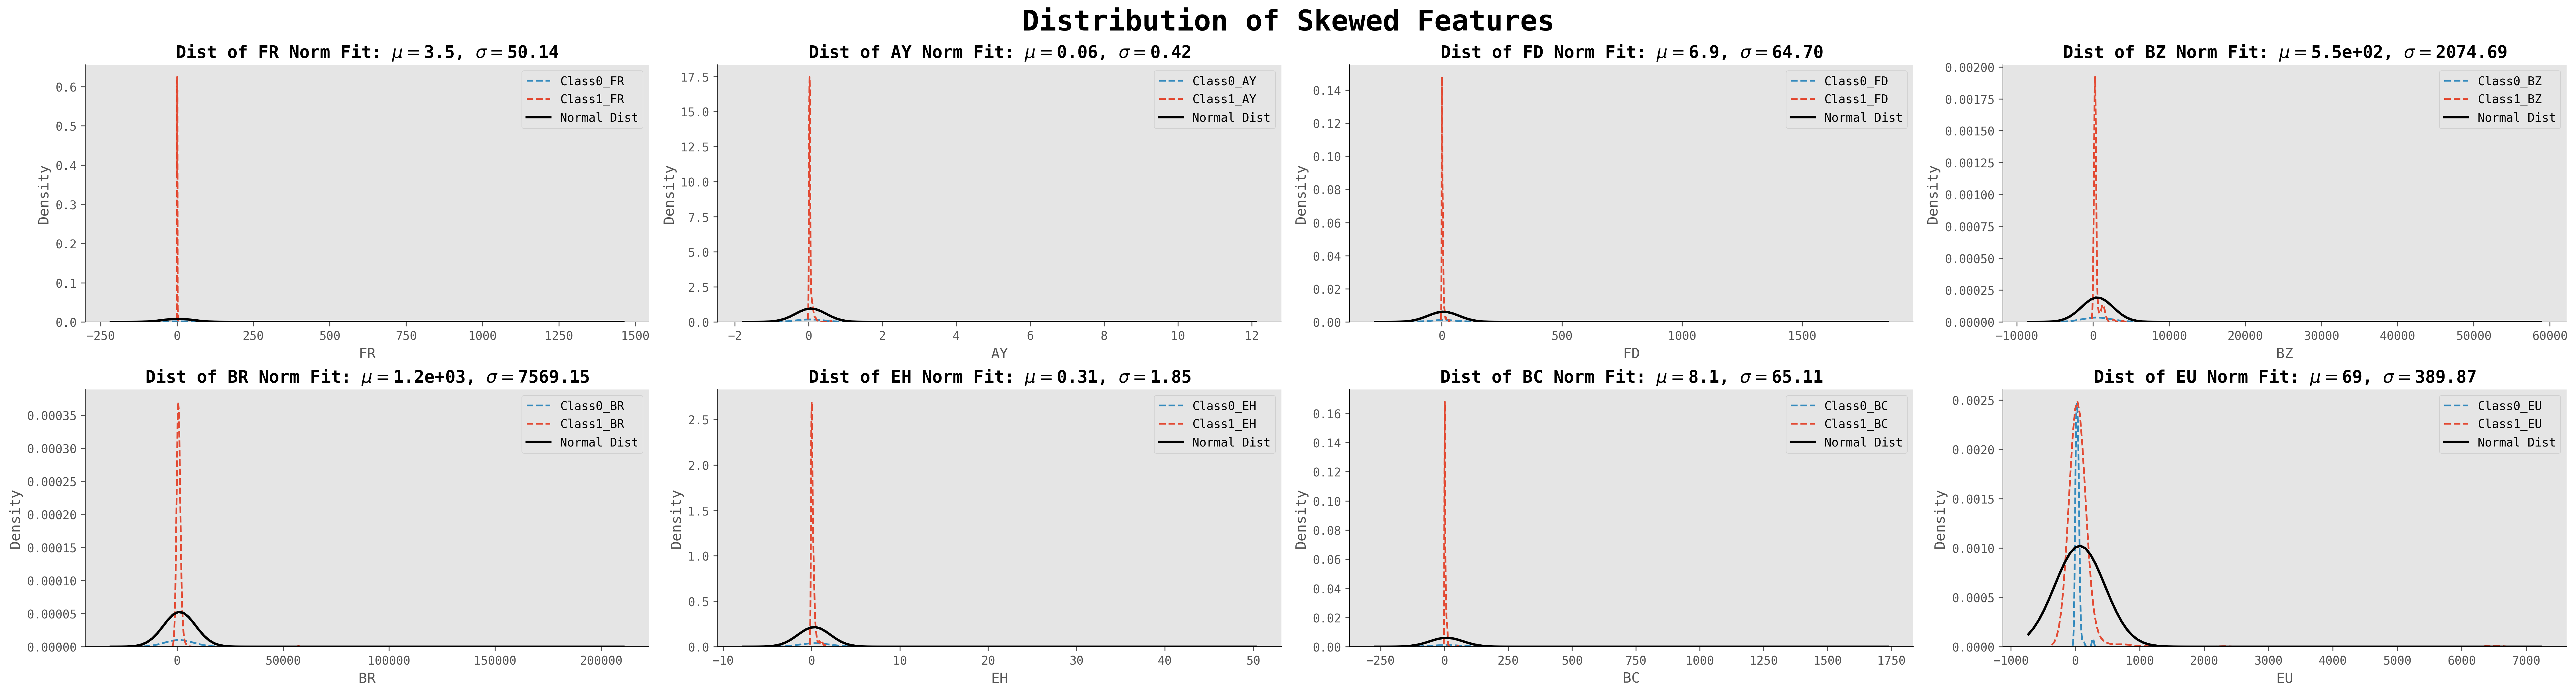

In [7]:
feat_dist(train, skewed.columns.tolist(), rows=2, columns=4, title='Distribution of Skewed Features', figsize=(30, 8))

Similar pattern here

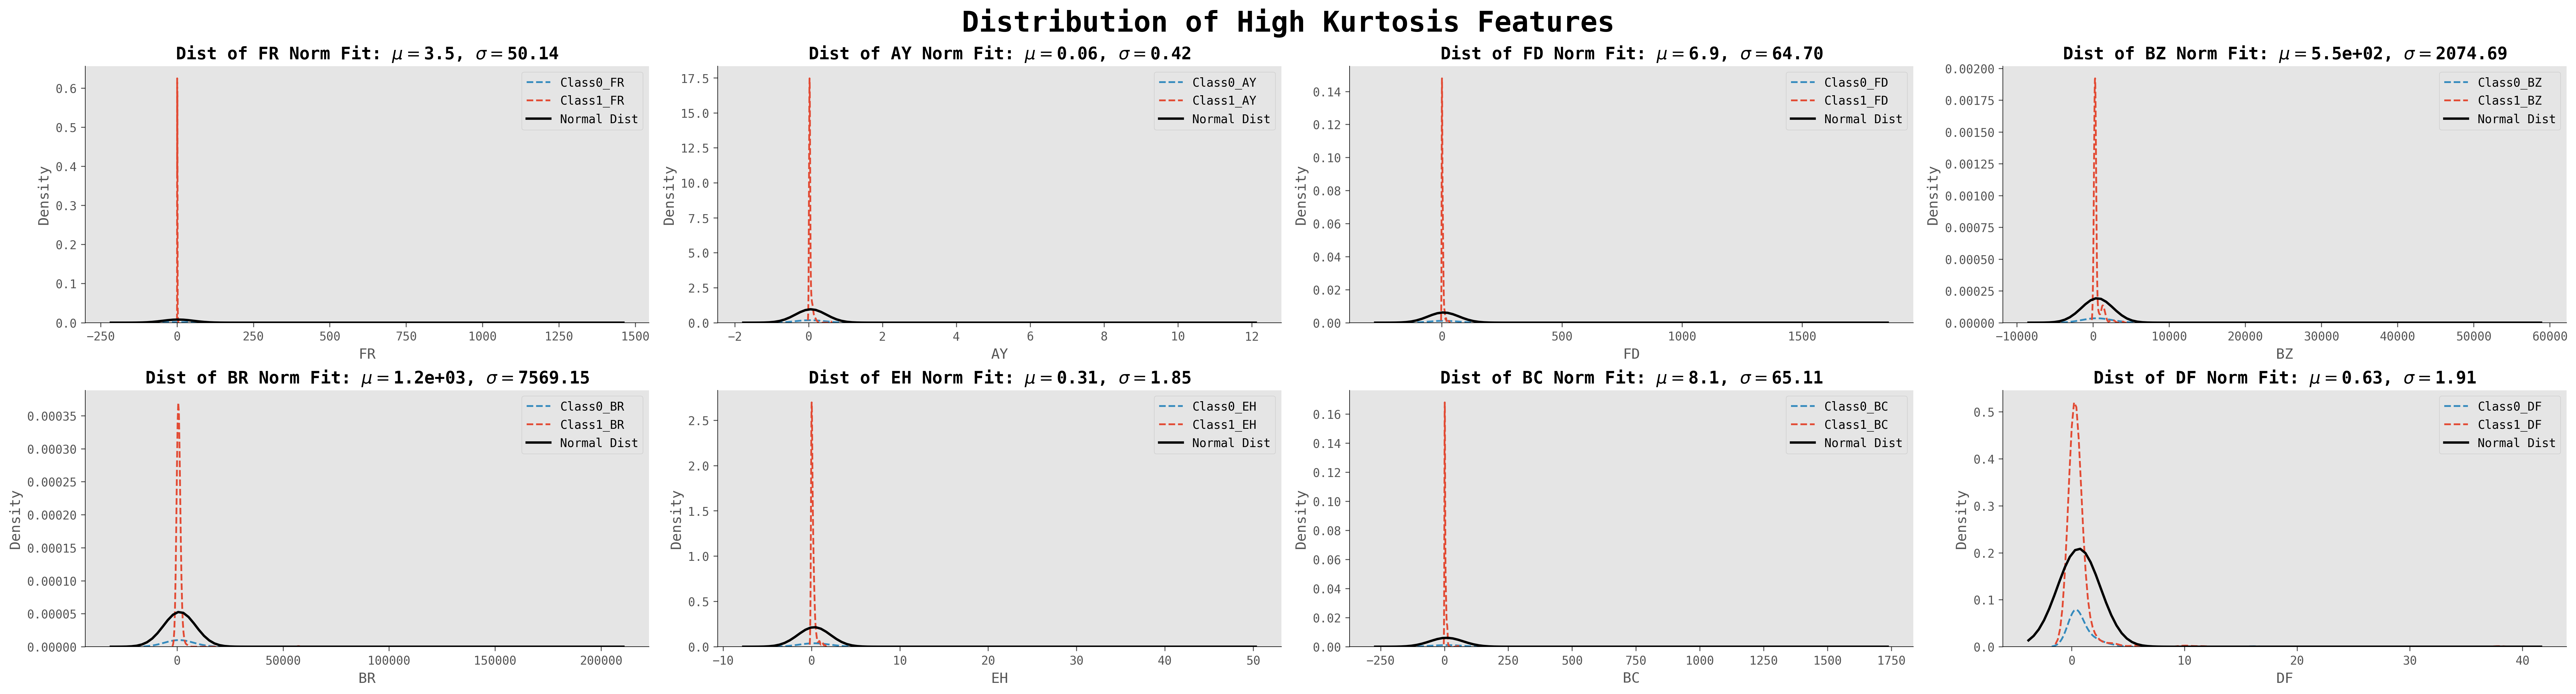

In [8]:
feat_dist(train, kurt_f.columns.tolist(), rows=2, columns=4, title='Distribution of High Kurtosis Features', figsize=(30, 8))

Let's take a look at most correlated features with target

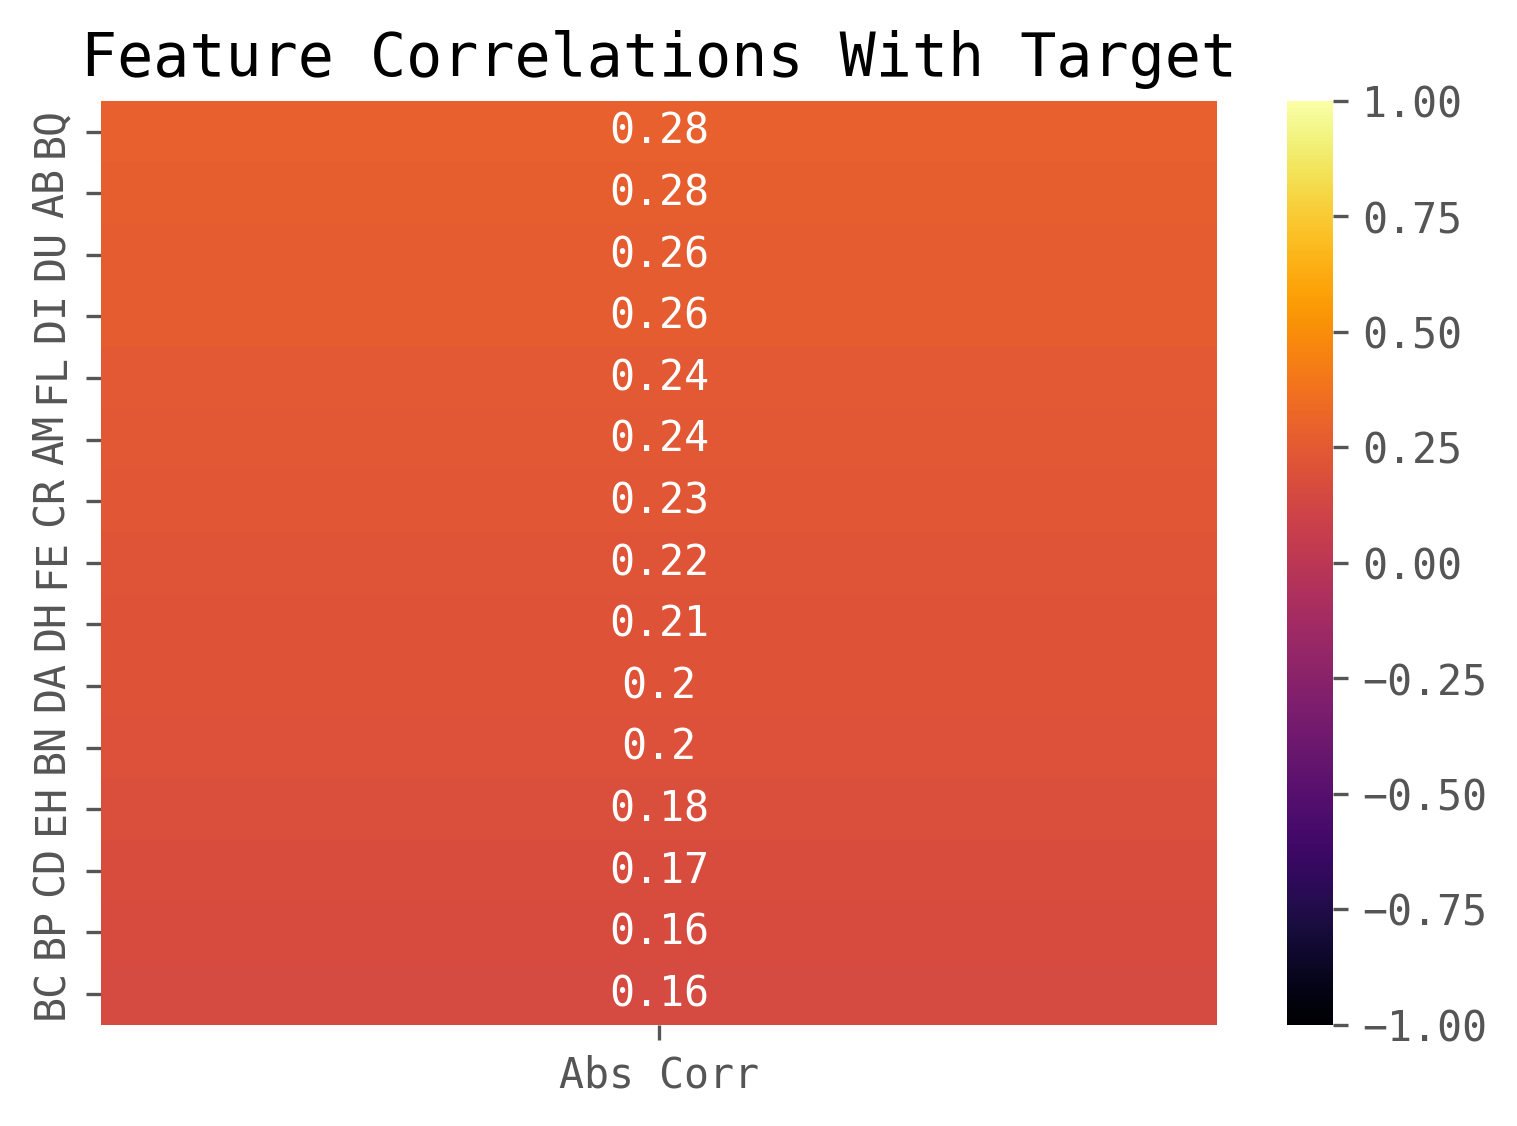

In [9]:
correlations = train.loc[:,num_cols].corrwith(train['Class']).to_frame()
correlations['Abs Corr'] = correlations[0].abs()
sorted_correlations = correlations.sort_values('Abs Corr', ascending=False)['Abs Corr']
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(sorted_correlations.iloc[1:].to_frame()[sorted_correlations>=.15], cmap='inferno', annot=True, vmin=-1, vmax=1, ax=ax)
plt.title('Feature Correlations With Target')
plt.show()

### Correlations Between Features

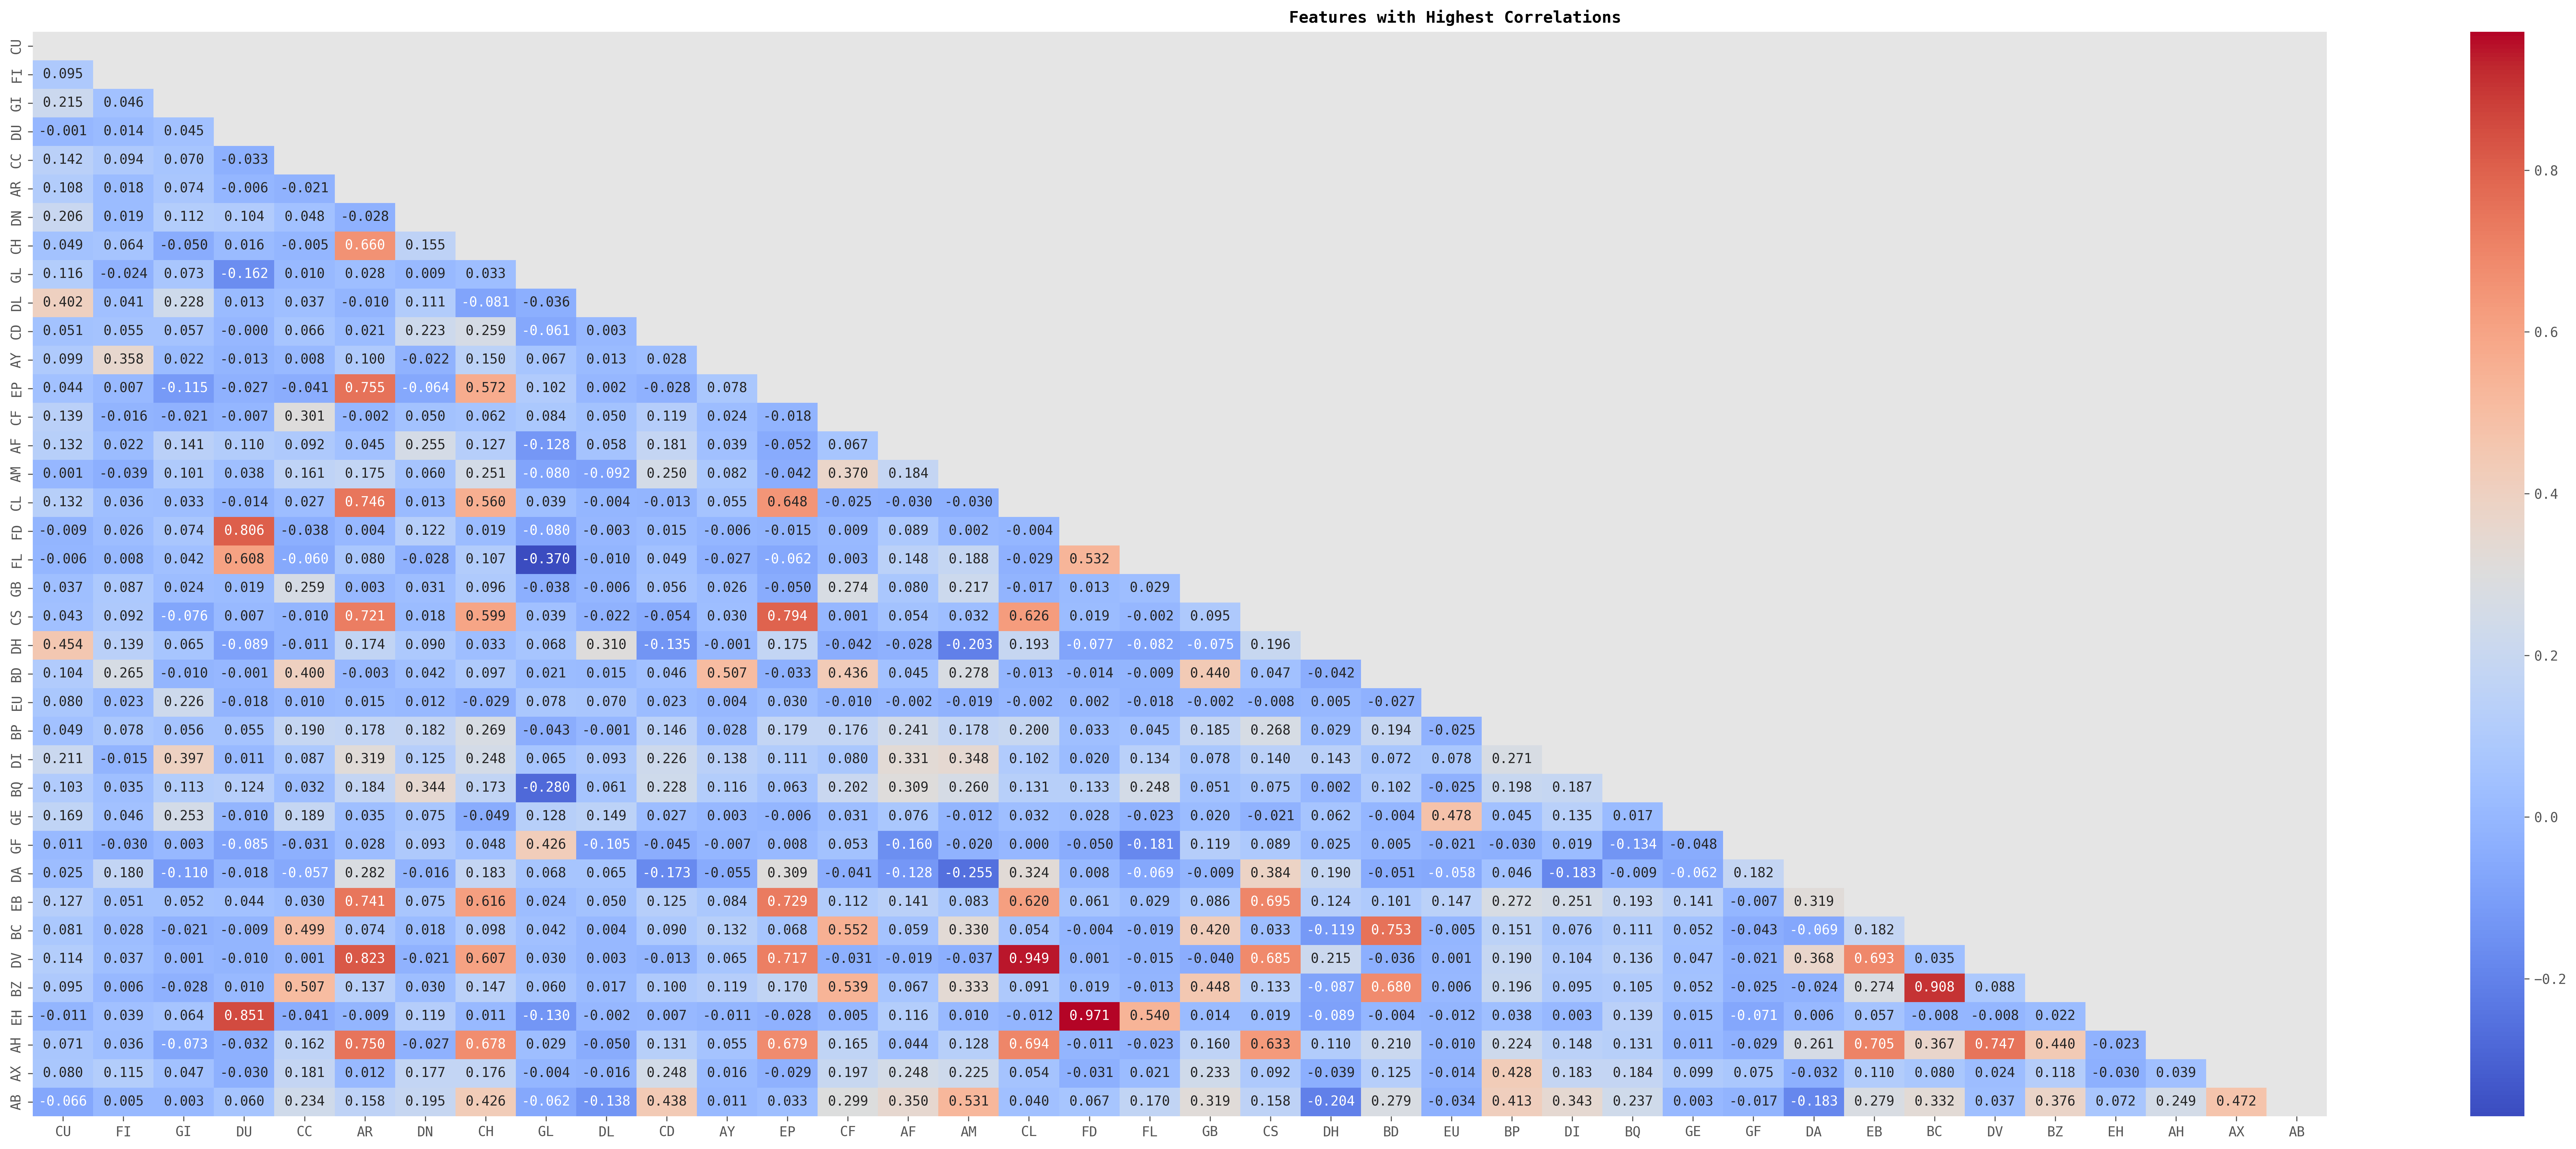

In [10]:
correlations = train.loc[:,num_cols].corr().abs().unstack().sort_values(kind="quicksort",ascending=False).reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']] #preventing 1.0 corr
corr_max=correlations.level_0.head(150).tolist()
corr_max=list(set(corr_max)) #removing duplicates

corr_min=correlations.level_0.tail(34).tolist()
corr_min=list(set(corr_min)) #removing duplicates


correlation_train = train.loc[:,corr_max].corr()
mask = np.triu(correlation_train.corr())

plt.figure(figsize=(30, 12))
sns.heatmap(correlation_train,
            mask=mask,
            annot=True,
            fmt='.3f',
            cmap='coolwarm',
            linewidths=0.00,
            cbar=True)


plt.suptitle('Features with Highest Correlations',  weight='bold')
plt.tight_layout()

### We can see some correlations, let's take another look:

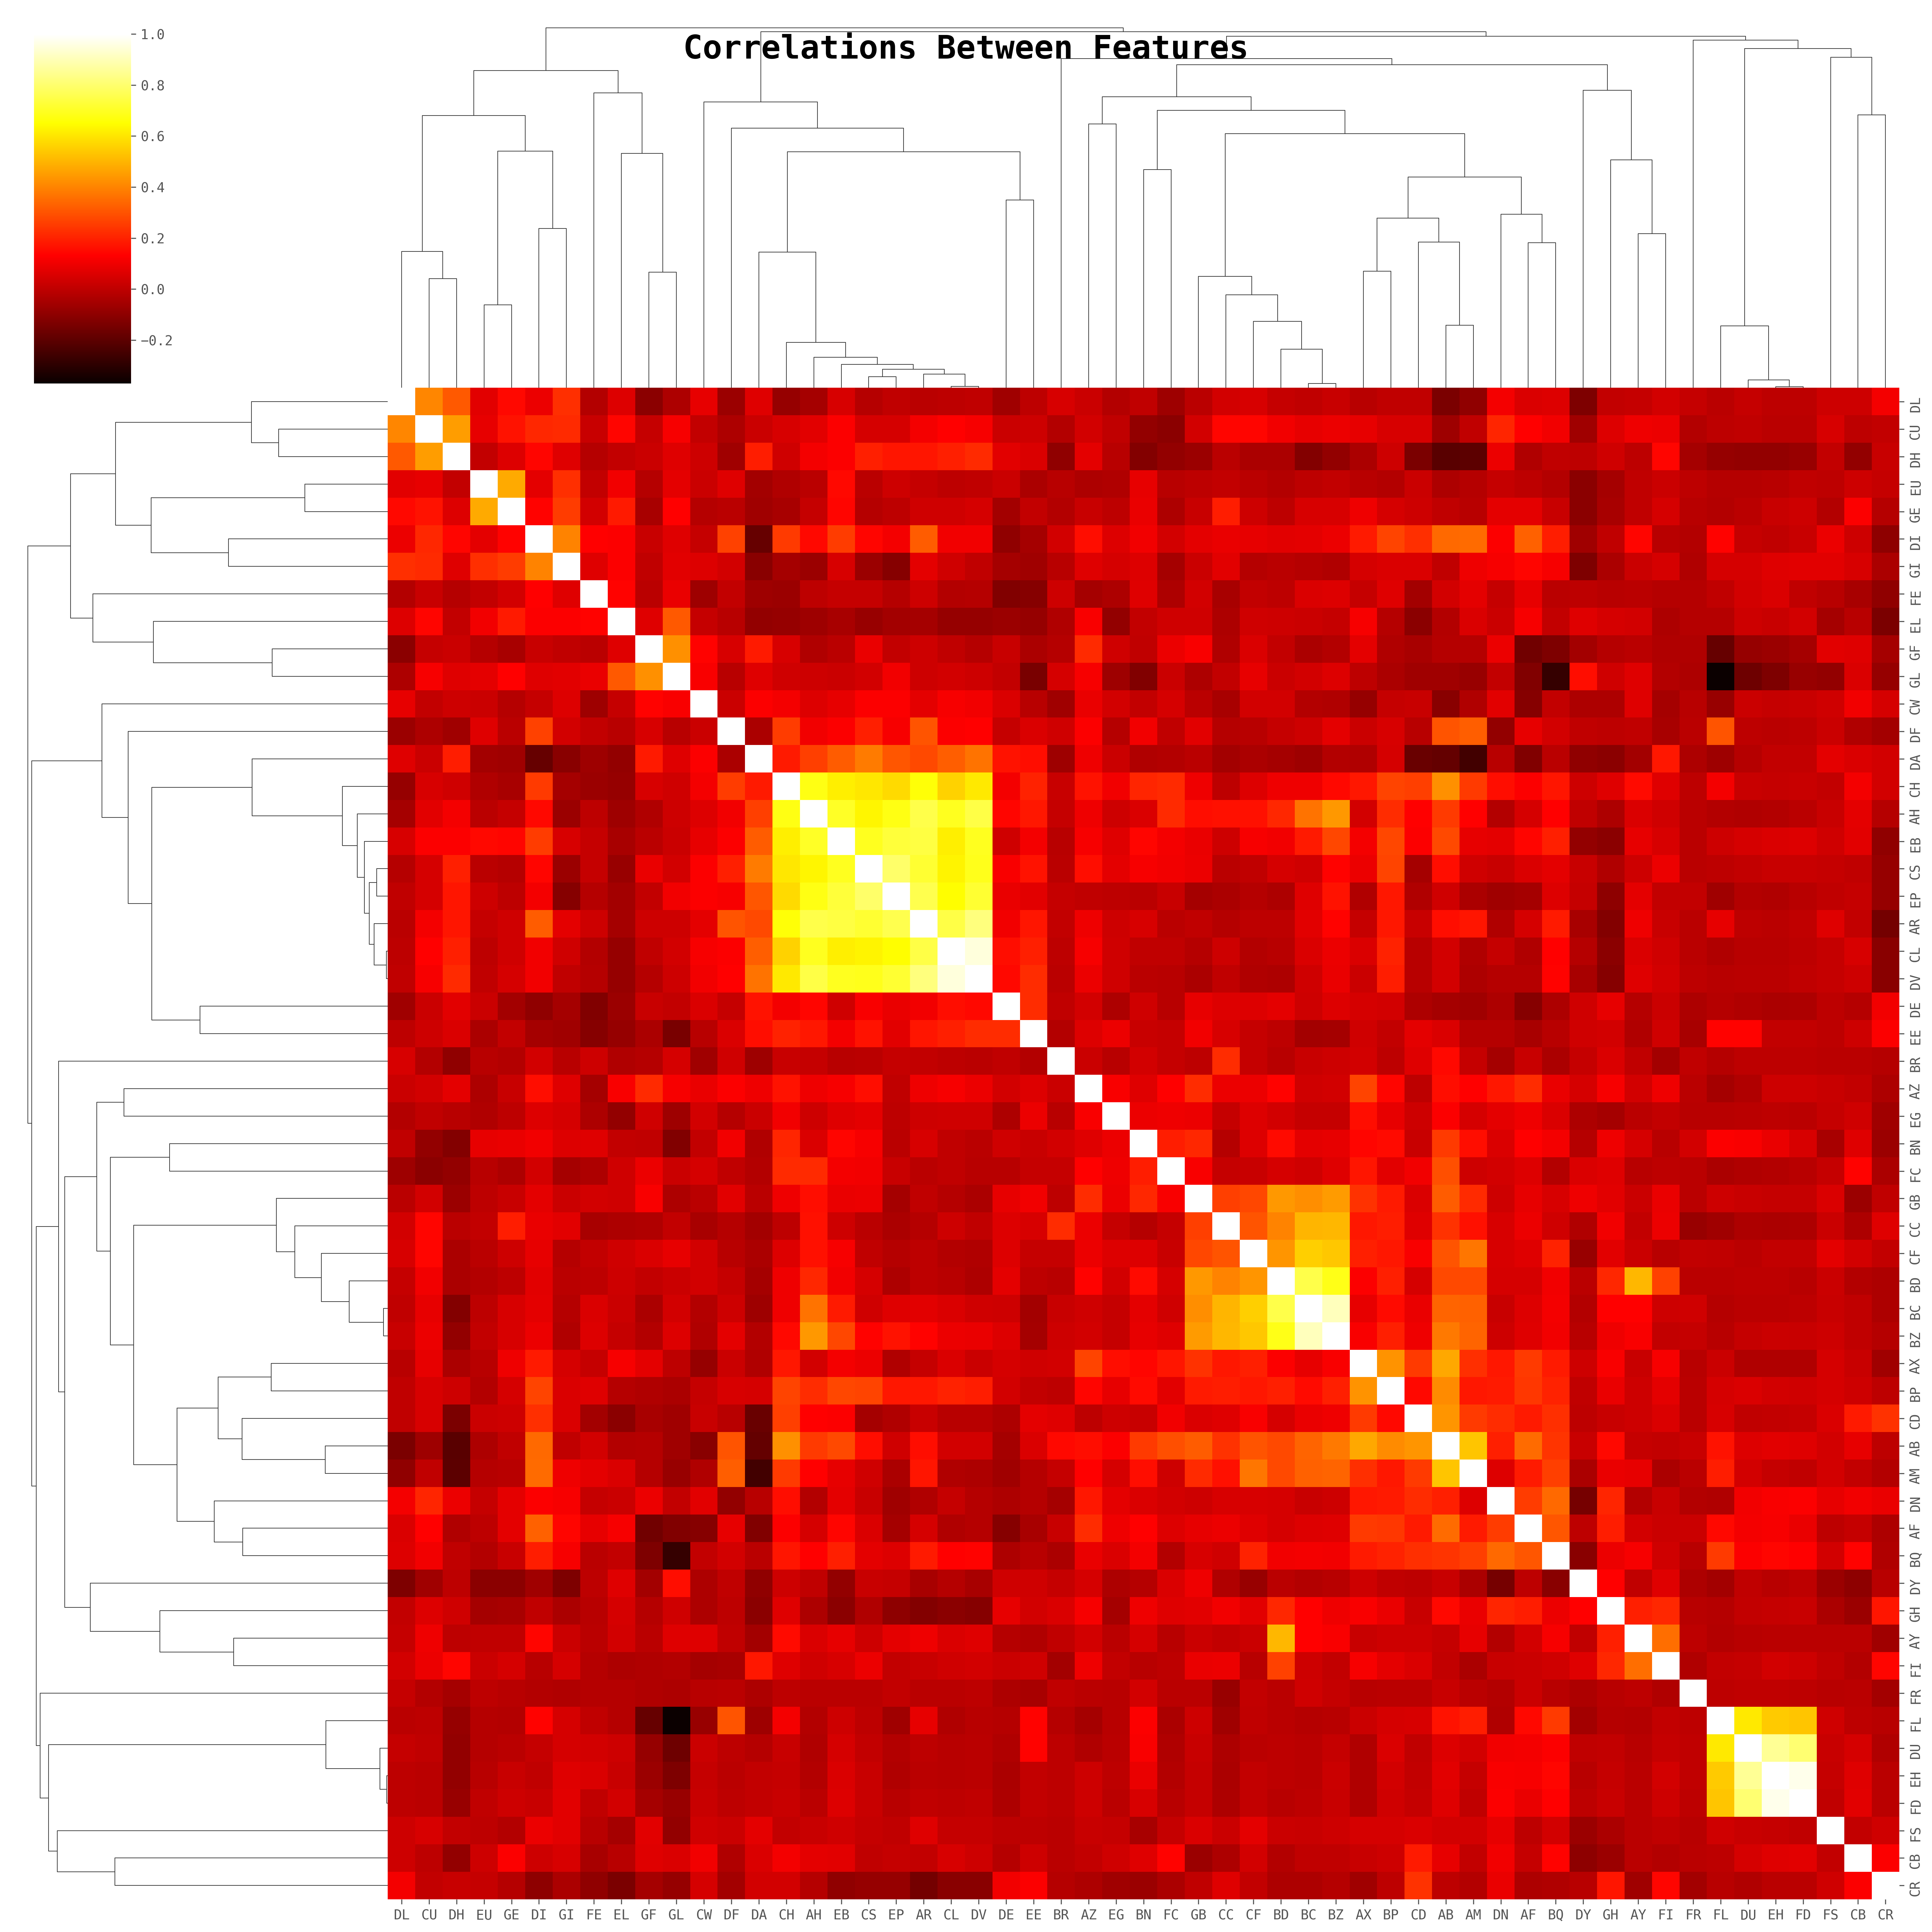

In [11]:
corr = train.loc[:, num_cols].corr()
sns.clustermap(corr, metric="correlation", cmap="hot", figsize=(20, 20))
plt.suptitle('Correlations Between Features', fontsize=24, weight='bold')
plt.show()

### Yes, there are definitely some strong correlated features. We should examine them further before making any conclusions.

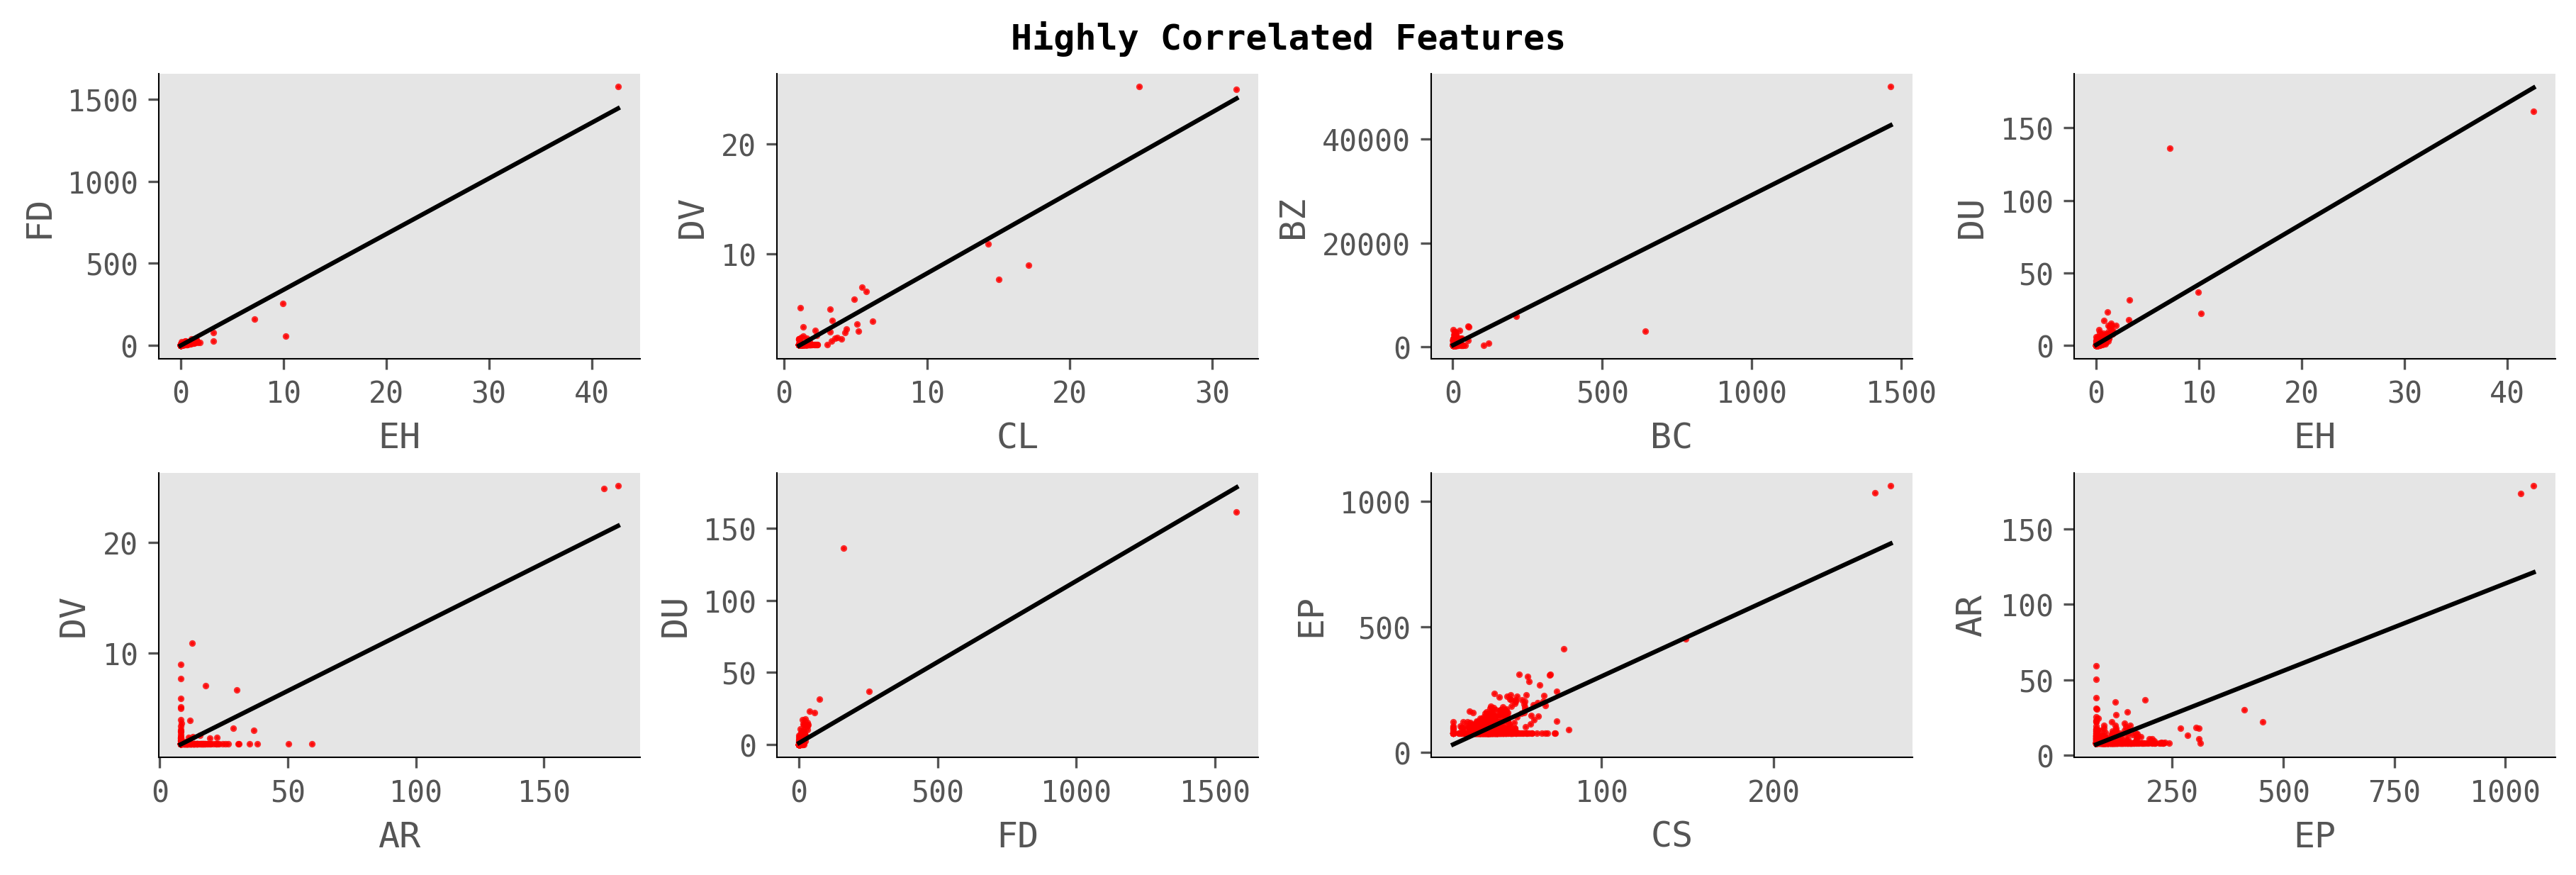

In [12]:
fig, axes = plt.subplots(2, 4, figsize=(12,4), constrained_layout=True)
axes = axes.flatten()

# for i, j in zip(cols, axes):
i = 0
for row in range(0,16,2):
    a = correlations.reset_index(drop=True).loc[row, ['level_0', 'level_1']][0]
    b = correlations.reset_index(drop=True).loc[row, ['level_0', 'level_1']][1]    
   
    sns.regplot(train, x=a, y=b, ci=False, ax=axes[i], order=1, scatter_kws={'color':'red', 's':1.5}, line_kws={'color':'black', 'linewidth':1.5})
    i+=1
    
plt.suptitle('Highly Correlated Features',  weight='bold')
plt.show()

### Some of these strongly correlated features are affected by outliers or influential points. Perhaps a more robust approach would make more sense.

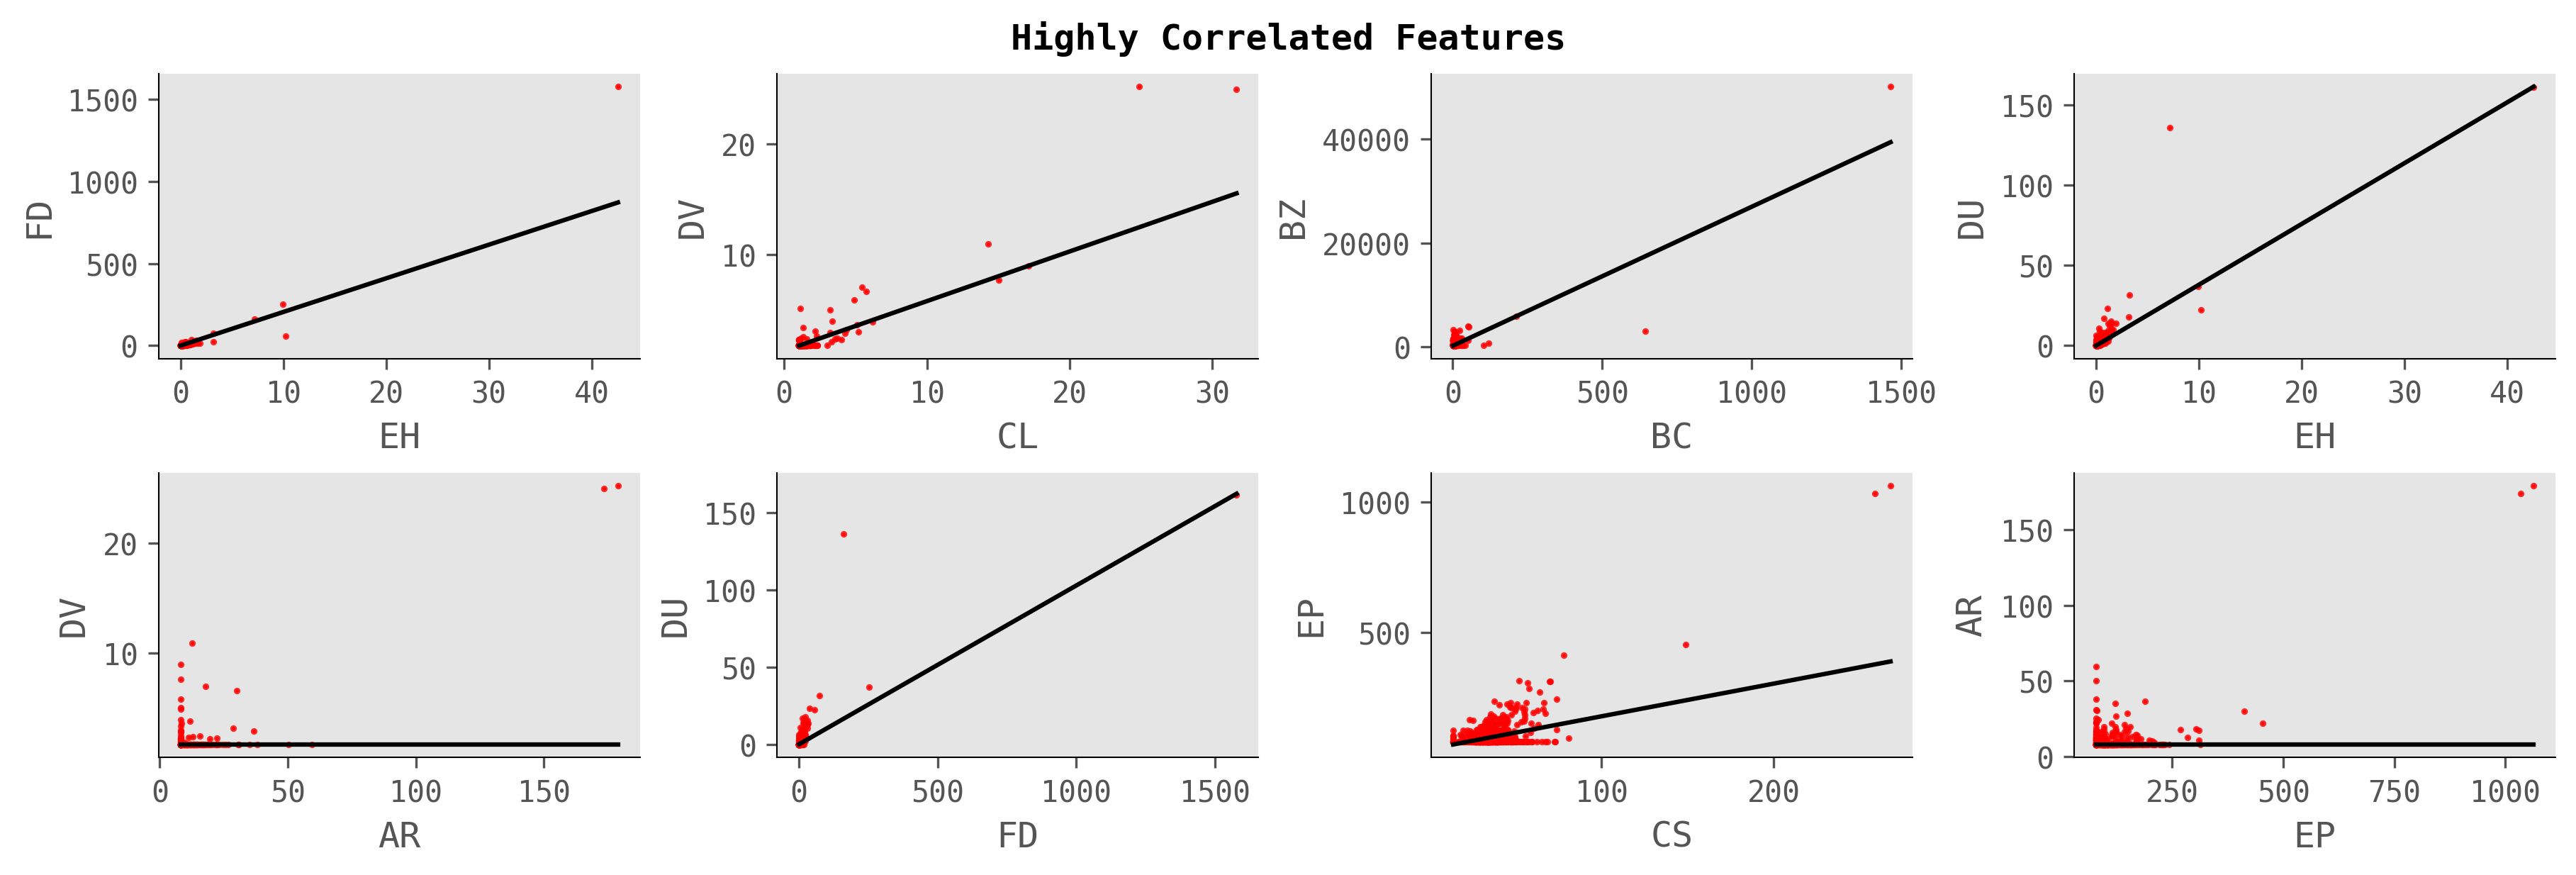

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(12,4), constrained_layout=True)
axes = axes.flatten()

# for i, j in zip(cols, axes):
i = 0
for row in range(0,16,2):
    a = correlations.reset_index(drop=True).loc[row, ['level_0', 'level_1']][0]
    b = correlations.reset_index(drop=True).loc[row, ['level_0', 'level_1']][1]
    
   
    sns.regplot(train, x=a, y=b, ci=False, ax=axes[i], robust=True, scatter_kws={'color':'red', 's':1.5}, line_kws={'color':'black', 'linewidth':1.5})
    i+=1
    
plt.suptitle('Highly Correlated Features',  weight='bold')
plt.show()

### Indeed, looks like some strong correlations are not as strong in practice, but we still see some retaining a degree of importance.

# Baseline Model

### This is the simplest form of baseline approach I implemented in the first place. Using class weights seems to help. Using "greeks.csv" data to stratify observations helped a little with variance between folds in my case...

In [14]:
# Create a LabelEncoder object.
encoder = LabelEncoder()
# Transform the data.
train[cat_cols] = encoder.fit_transform(train[cat_cols])
test[cat_cols] = encoder.transform(test[cat_cols])

In [15]:
oof = np.zeros((len(train), 2))

skf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

final_preds = []

params={
    'iterations':10000,
    'learning_rate':0.005,
    'early_stopping_rounds':1000,
    'auto_class_weights':'Balanced',
    'loss_function':'MultiClass',
    'eval_metric':'MultiClass:use_weights=True',
    'random_seed':42,
    'use_best_model':True,
    'l2_leaf_reg':1,
    'max_ctr_complexity':15,
    'max_depth':10,
    "grow_policy":'Lossguide',
    'max_leaves':64,
    "min_data_in_leaf":40,

    }

for train_index,val_index in skf.split(train, greeks.iloc[:,1:-1]):

    X_train, X_val = train.loc[train_index, num_cols + [cat_cols]], train.loc[val_index, num_cols + [cat_cols]]
    y_train, y_val = train.loc[train_index, 'Class'], train.loc[val_index, 'Class']
    
    
    model = cb.CatBoostClassifier(**params)
    model.fit(X_train,y_train,eval_set=[(X_val,y_val)], verbose=1000)
    preds = model.predict_proba(X_val)
    oof[val_index, :] = preds
    final_preds.append(model.predict_proba(test.iloc[:,1:]))

0:	learn: 0.6907267	test: 0.6912612	best: 0.6912612 (0)	total: 66ms	remaining: 10m 59s
1000:	learn: 0.0998772	test: 0.3644460	best: 0.3633853 (992)	total: 10.4s	remaining: 1m 33s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.3633853116
bestIteration = 992

Shrink model to first 993 iterations.
0:	learn: 0.6909054	test: 0.6911446	best: 0.6911446 (0)	total: 11.2ms	remaining: 1m 52s
1000:	learn: 0.1053599	test: 0.2726799	best: 0.2726799 (1000)	total: 10s	remaining: 1m 29s
2000:	learn: 0.0230848	test: 0.2533569	best: 0.2511949 (1708)	total: 20.4s	remaining: 1m 21s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.2511949429
bestIteration = 1708

Shrink model to first 1709 iterations.
0:	learn: 0.6907639	test: 0.6910948	best: 0.6910948 (0)	total: 10.9ms	remaining: 1m 49s
1000:	learn: 0.1025662	test: 0.2475667	best: 0.2475667 (1000)	total: 10s	remaining: 1m 30s
2000:	learn: 0.0239101	test: 0.1919123	best: 0.1919123 (2000)	total: 19.7s	remaining: 1m

 This is my quick draft implementation of the competition metric. I am not sure if it's working as intended but seems to be in line with other metrics. But anyways take it with a grain of salt, please let me know if there's something wrong...

Updated the metric based on this [discussion](https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/410864). It seems to get CV and LB closer, but correlation still similar with old implementation:

![](https://i.imgur.com/4FcxvaO.png)

In [16]:
def balance_logloss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    y_pred / np.sum(y_pred, axis=1)[:, None]
    nc = np.bincount(y_true)
    
    logloss = (-1/nc[0]*(np.sum(np.where(y_true==0,1,0) * np.log(y_pred[:,0]))) - 1/nc[1]*(np.sum(np.where(y_true!=0,1,0) * np.log(y_pred[:,1])))) / 2
    
    return logloss

balance_logloss(train['Class'], oof)

0.26679282403883736

You can also use something like this for sanity check, seems reproducing similar scores:

In [17]:
from sklearn.metrics import log_loss

def balance_loglossv2(y_true, y_pred):
    target_mean = y_true.mean()
    w0 = 1/(1-target_mean)
    w1 = 1/target_mean
    sample_weight = [w0 if y == 0 else w1 for y in y_true]
    loss = log_loss(y_true, y_pred, sample_weight=sample_weight)
    
    return loss

print(balance_loglossv2(train['Class'], oof))  

0.2667928240388374


### Submission

In [18]:
sample_submission = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')
sample_submission[['class_0','class_1']] = np.mean(final_preds, axis=0)
sample_submission.to_csv('submission.csv',index=False)
sample_submission

Id   class_0   class_1
0  00eed32682bb  0.774959  0.225041
1  010ebe33f668  0.774959  0.225041
2  02fa521e1838  0.774959  0.225041
3  040e15f562a2  0.774959  0.225041
4  046e85c7cc7f  0.774959  0.225041

### Thanks!